# Introduction to BERT
In this notebook, we'll take a deeper look at BERT ([Devlin et al., 2019](https://arxiv.org/abs/1810.04805)), one of the most versatile and powerful models in the field of Natural Language Processing (NLP). 

We will aim to cover the following topics:
* The BERT paper and architecture
* The BERT extended family
* Exploration of BERT, including the tokenizer, embeddings, and tasks we can do with BERT
* Bias in BERT

## The BERT Paper and Architecture

### Architecture
BERT, like many other modern language models, is based on the _transformer architecture_. 

The implementation of the attention mechanism for BERT was almost identical to that of the original model in the "_Attention is All You Need"_ paper ([Vaswani et al., 2017](https://arxiv.org/abs/1706.03762)).

There is a key difference between many other well-known models, like ChatGPT and BERT: BERT is a **bidirectional model**. This means that it can look at the _entire context of a word_ when making predictions, rather than just the words that come before it. This is a significant advantage, as it allows BERT to capture more complex relationships between words.

BERT comes in two sizes - **BERT Base** and **BERT Large**. BERT Base has 12 layers, 768 hidden units, and 12 attention heads for a total of 110M parameters, while BERT Large has 24 layers, 1024 hidden units, and 16 attention heads and 340M total parameters. 

The larger model is more powerful, but also more computationally expensive. Despite being small when compared to many LLMs, BERT is still a large model, and training it requires a lot of computational resources.

### Training
BERT was trained on two tasks:

1. **Masked token prediction**: 15% of the words in each sentence were masked and the model was trained to predict the masked words.

2. **Next sentence prediction**: The model was trained to predict whether the second sentence in a pair of sentences was the actual next sentence in the original document.

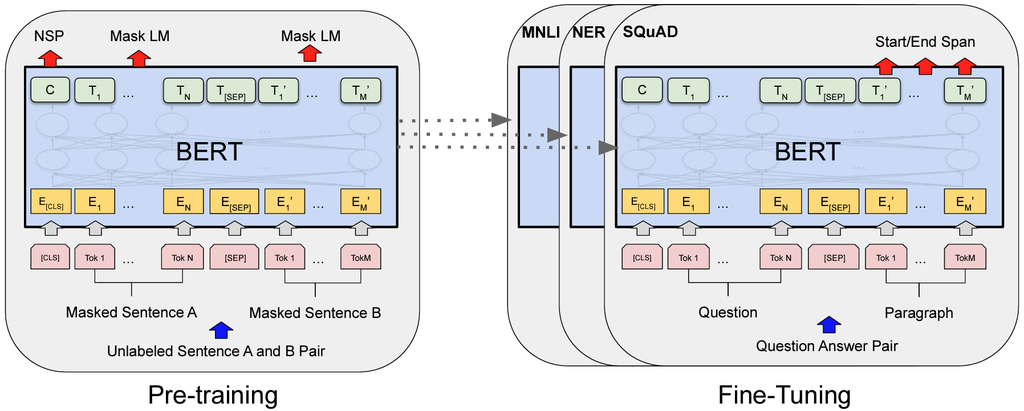

###

## The BERT Family
The BERT family tree is actually vast and includes many different models, each with its own unique characteristics. Here are some of the most important members of the BERT family:

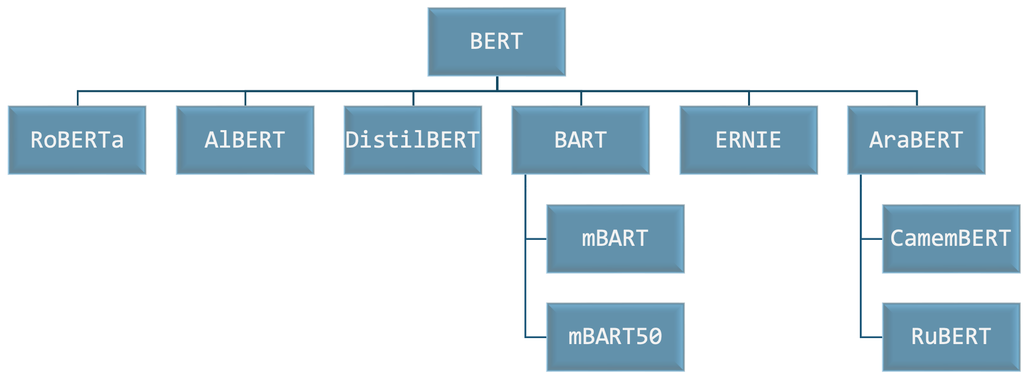

Many of these models have quite specific use cases, so we will only briefly cover some of them here.

### DistilBERT
**DistilBERT** is a smaller version of BERT that was designed to be faster and more efficient ([Sanh et al., 2019](https://arxiv.org/abs/1910.01108)). 

It's smaller than BERT Base, but still performs well on many tasks. It is *probably the most versatile and lightweight model in the BERT family*.

DistilBERT also applied the training technique of "_knowledge distillation_" on language models. This technique involves training a smaller model to mimic the behaviour of a larger model. This allows the smaller model to learn from the larger model's predictions, which can improve its performance.

#### Knowledge distillation
In supervised learning -- for example classification problems -- a model is typically trained to predict some class by maximising the estimated probability of the correct class. The training objective is to mimimise the cross-entropy between the model's predicted distribution and the true distribution.

A good model will have a distribution with high values for the correct class and low values for the incorrect classes. However, these low values are not meaningless! They contain information about the model's generalisation capabilities. Knowledge distillation aims to use this information. 

The final layer in most networks is a softmax function:
$$
\hat{y}_i (x|t) = \frac{e^{z_i/t}}{\sum_{j} e^{z_j/t}}
$$
where $z_i$ are the output logits of the final layer for class $i$, and $t$ is the _temperature parameter_.

The student model is trained with a loss over the target probabilities produced by the student, $y_i$, and the teacher's predicted probabilities, $\hat{y}_i$:
$$
L_{\text{distill}} = -t^2 \sum_{i} \hat{y}_i(x|t) \log y_i(x|t)
$$

The temperature parameter here will increase the entropy of the output and provides more information for the distilled model compared to the "hard" targets of a standard softmax output.

In addition to the standard cross-entropy loss:
$$
L_{\text{CE}} = -\sum_{i} \bar{y}_i \log\hat{y}_i(x|1)
$$
Finally, a cosine embedding loss is added to align the directions of the two models hidden vectors.

All this to say that a model with 40% fewer parameters can be trained to achieve about 97% of the peroformance of BERT.

### RoBERTa
**RoBERTa** was one of the first models to directly build upon and improve BERT. 

Certain key hyperameters were modified, and the model was trained on more data for longer, including a subset of the Common Crawl ([Nagel, 2016](https://commoncrawl.org/blog/news-dataset-available)) and Open WebText ([Gokaslan and Cohen, 2019](https://skylion007.github.io/OpenWebTextCorpus/)). The next sentence classification task was also removed.

RoBERTa essentially uses the same architecture as BERT, but with a very important difference: the tokenizer uses a byte-level *Byte-Pair Encoding (BPE)* algorithm, which allows it to handle *out-of-vocabulary* words more effectively. This is a significant improvement over BERT, which uses a *WordPiece* tokenizer. To note, it also uses `</s>` as the sentence separator token, rather than `SEP`.

This model was extended to French in the *CamemBERT* model ([Martin et al., 2019](https://arxiv.org/abs/1911.03894)), and 100 different languages in *XLM-RoBERTa* ([Conneau et al., 2019](https://arxiv.org/abs/1911.02116)).

### BART
**BART**'s architecture is quite different from BERT in a key way - it has a GPT-like decoder, as well as the BERT encoder. This makes it a *sequence-to-sequence* model.

BART is a model that was designed to be a denoising autoencoder for pretraining. It is based on the transformer architecture, but with a few key differences. The model is trained to *predict the original sentence given a corrupted version of it*. This is done by corrupting the input sentence in various ways, such as by removing words, swapping words, or changing words.

# Exploration of BERT
In this section, we will explore BERT using the Hugging Face `transformers` library. 

First, we will look more closely at BERT's tokenizer, and then we will use the `transformers` library to load a pre-trained BERT model and tokenizer, and generate embeddings for a sentence. We can practically see how BERT genenerates contextual embeddings for the same word in different contexts.

### BERT's Tokenizer
Earlier, we mentioned that BERT uses a WordPiece tokenizer, and RoBERTa uses a byte-level Byte-Pair Encoding (BPE) tokenizer. Google never publicly released the WordPiece algorithm, so we can only make educated guesses as to how it actually works.

WordPiece is a subword tokenization algorithm that splits whole words into subwords. WordPiece recognizes subwords by adding a prefix `##` to the following subwords. For example:

`barking` -> `[bark, ##ing]`

WordPiece then learns how to merge subwords. Byte-level BPE is similar to WordPiece, but it uses bytes as the basic unit of tokenization, and it's merging rules are slightly different. This allows it to handle out-of-vocabulary words more effectively.

For more details on the differences check out these Hugging Face tutorials on [WordPiece](https://huggingface.co/learn/nlp-course/en/chapter6/6) and [BPE](https://huggingface.co/learn/nlp-course/en/chapter6/5) tokenizations.

An important thing to note is that if you want to add new tokens, **you will need to train a new tokenizer from scratch**.

Let's have a look at how BERT and RoBERTa tokenize sentences:

In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

from rich.pretty import pprint

In [2]:
from transformers import AutoModel, AutoTokenizer

bert_tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-base-uncased")
roberta_tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")

text = "The quick brown fox jumps over the lazy dog"

/home/vscode/.local/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


The `tokenizer` object has some important methods:

* `encode`: Tokenizes a sentence and returns a list of token IDs.

* `decode`: Converts a list of token IDs back into a sentence.

* `tokenize`: Tokenizes a sentence and returns a list of tokens.

In [3]:
# We can use tokenize to convert the text to tokens
bert_tokens = bert_tokenizer.tokenize(text)
roberta_tokens = roberta_tokenizer.tokenize(text)

bert_encoded = bert_tokenizer.encode(text)
roberta_encoded = roberta_tokenizer.encode(text)

In [4]:
print(
    "BERT tokenizer:\n"
    f"{bert_tokens}\n\n"
    f"RoBERTa tokenizer:\n"
    f"{roberta_tokens}"
    )

BERT tokenizer:
['the', 'quick', 'brown', 'fox', 'jumps', 'over', 'the', 'lazy', 'dog']

RoBERTa tokenizer:
['The', 'Ġquick', 'Ġbrown', 'Ġfox', 'Ġjumps', 'Ġover', 'Ġthe', 'Ġlazy', 'Ġdog']


Notice that for RoBERTa, the tokenizer includes this odd special character `Ġ` at the start of a full word. Also notice that the default RoBERTa is cased - so capitalization is preserved.

In [5]:
print(
    "BERT tokenizer:\n"
    f"{bert_encoded}\n\n"
    f"RoBERTa tokenizer:\n"
    f"{roberta_encoded}"
    )

BERT tokenizer:
[101, 1996, 4248, 2829, 4419, 14523, 2058, 1996, 13971, 3899, 102]

RoBERTa tokenizer:
[0, 133, 2119, 6219, 23602, 13855, 81, 5, 22414, 2335, 2]


Notice that we have more actual tokens here than we had words in the sentence! In particular, we have the special tokens for BERT: `[101]` and `[102]`, and for RoBERTa: `[0]` and `[2]`.

In [6]:
bert_decoded = bert_tokenizer.decode(bert_encoded)
roberta_decoded = roberta_tokenizer.decode(roberta_encoded)

print(
    "BERT tokenizer:\n"
    f"{bert_decoded}\n\n"
    f"RoBERTa tokenizer:\n"
    f"{roberta_decoded}"
    )

BERT tokenizer:
[CLS] the quick brown fox jumps over the lazy dog [SEP]

RoBERTa tokenizer:
<s>The quick brown fox jumps over the lazy dog</s>


The special tokens are as follows:
* `[CLS]` / `<s>` (`101` / `0`): Marks the beginning of a sentence.

* `[SEP]` / `</s>` (`102` / `2`): Marks the end of a sentence.

For BERT, the token `[MASK]` is also used to mark masked tokens. The `[CLS]` token was used originally for the next sentence prediction task during pretraining.

Typically we use the `[CLS]` token for sentence embeddings. This wasn't intentional on the part of the authors, and the `[CLS]` token is not in and of itself semantically meaningful. Indeed, Jacob Devlin, one of the original BERT authors said:

>_"I'm not sure what these vectors are, since BERT does not generate meaningful sentence vectors. It seems that this is doing average pooling over the word tokens to get a sentence vector, but we never suggested that this will generate meaningful sentence representations. And even if they are decent representations when fed into a DNN trained for a downstream task, it doesn't mean that they will be meaningful in terms of cosine distance. (Since cosine distance is a linear space where all dimensions are weighted equally)."_

However, we can still use the `[CLS]` token for sentence embeddings, and it works well in practice when fine-tuning BERT for downstream tasks. Just remember: _**these embeddings are not semantically meaningful on their own!**_ In other words, it does not necessarily make sense to do cosine similarity between two sentence embeddings generated by BERT.

**IMPORTANT**: *When using BERT family models, if you do not include these special tokens, the model will not perform to its full potential. This is because the model was trained with these tokens, and it expects them to be present in the input.*

Let's see how RoBERTa and BERT tokenize a very long word.

In [7]:
long_word = "antidisestablishmentarianism"
bert_tokens = bert_tokenizer.tokenize(long_word)
roberta_tokens = roberta_tokenizer.tokenize(long_word)

In [8]:
print(
    "BERT tokenizer:\n"
    f"{bert_tokens}\n\n"
    f"RoBERTa tokenizer:\n"
    f"{roberta_tokens}"
    )

BERT tokenizer:
['anti', '##dis', '##est', '##ab', '##lish', '##ment', '##arian', '##ism']

RoBERTa tokenizer:
['ant', 'idis', 'establishment', 'arian', 'ism']


As mentioned above, BERT uses a WordPiece algorithm which includes the extra `##` token to indicate that a word is a subword. This is not necessary for RoBERTa.

We can also call the tokenizer directly on a sentence to get an input for the model:

We can also use BERT to generate embeddings for a sentence.

In [9]:
encoded_input = bert_tokenizer(text, return_tensors='pt')

In [10]:
pprint(encoded_input)

{
│   'input_ids': tensor([[  101,  1996,  4248,  2829,  4419, 14523,  2058,  1996, 13971,  3899,
│   │      102]]),
│   'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]]),
│   'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]])
}

We have here three different tensors:
* `input_ids`: The tokenized sentence

* `attention_mask`: A tensor that indicates which tokens are padding tokens and which are not

* `token_type_ids`: A tensor that indicates which tokens belong to which sentence in a pair of sentences

`token_type_ids` is only used when we are working with a pair of sentences. In this case, we only have one sentence, so we can ignore it.

The `attention_mask` is all 1s at the moment, but what if we needed to batch inputs? We would need to pad the inputs to the same length, and then we would use the `attention_mask` to indicate which tokens are padding tokens and which are not:

In [11]:
texts = [
    "I love pizza",
    "I hate Mondays",
    "I like chocolate ice cream"
]

encoded_input = bert_tokenizer(texts, return_tensors='pt', padding=True)
pprint(encoded_input)

{
│   'input_ids': tensor([[  101,  1045,  2293, 10733,   102,     0,     0],
│   │   [  101,  1045,  5223, 28401,   102,     0,     0],
│   │   [  101,  1045,  2066,  7967,  3256,  6949,   102]]),
│   'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0],
│   │   [0, 0, 0, 0, 0, 0, 0],
│   │   [0, 0, 0, 0, 0, 0, 0]]),
│   'attention_mask': tensor([[1, 1, 1, 1, 1, 0, 0],
│   │   [1, 1, 1, 1, 1, 0, 0],
│   │   [1, 1, 1, 1, 1, 1, 1]])
}

Now we can see that the attention masks are actually useful. We have padded the two shorter sentences with zeros, and the attention mask indicates which tokens are padding tokens and which are not. This way we can send batches of inputs to the model without worrying about the padding tokens affecting the output.

If we want all `input_ids` to have the same length, and we want to cut off sentences after a certain length, we can use the `truncation` strategy:

In [12]:
texts = [
    "I love pizza",
    "I hate Mondays",
    "I like chocolate ice cream"
]

encoded_input = bert_tokenizer(texts, return_tensors='pt', max_length=6, padding=True, truncation=True)
pprint(encoded_input)

{
│   'input_ids': tensor([[  101,  1045,  2293, 10733,   102,     0],
│   │   [  101,  1045,  5223, 28401,   102,     0],
│   │   [  101,  1045,  2066,  7967,  3256,   102]]),
│   'token_type_ids': tensor([[0, 0, 0, 0, 0, 0],
│   │   [0, 0, 0, 0, 0, 0],
│   │   [0, 0, 0, 0, 0, 0]]),
│   'attention_mask': tensor([[1, 1, 1, 1, 1, 0],
│   │   [1, 1, 1, 1, 1, 0],
│   │   [1, 1, 1, 1, 1, 1]])
}

### Contextual embeddings

So then how do we generate contextual output from BERT?

In [13]:
# First let's import BertModel from transformers
from transformers import BertModel

In [14]:
text = "The quick brown fox jumps over the lazy dog"
encoded_input = bert_tokenizer(text, return_tensors='pt')

bert_model = BertModel.from_pretrained("bert-base-uncased")

output = bert_model(**encoded_input, output_hidden_states=True)

pprint(output.keys())

odict_keys(['last_hidden_state', 'pooler_output', 'hidden_states'])

In [16]:
print(output['last_hidden_state'].shape)
print(output['pooler_output'].shape)
print(len(output['hidden_states']))
print(output['hidden_states'][0].shape)

torch.Size([1, 11, 768])
torch.Size([1, 768])
13
torch.Size([1, 11, 768])


So what are these?

* `last_hidden_state`: The hidden states of the model at the output of each layer. In the case of our input sentence, the output has shape `(1, num_tokens, hidden_size)`, where `num_tokens` is the number of tokens in the input sentence (11, because remember we also have special tokens) and `hidden_size` is the size of the hidden layer (768 for BERT Base).

* `pooler_output`: The output of the model after passing the `[CLS]` token through a linear layer and a tanh activation function. The weights from this layer are those obtained during the sentence prediction task during pre-training.

* `hidden_states`: The hidden states of the model at the output of each layer. This is a list of length `num_hidden_layers + 1`, where `hidden_states[i]` is a tensor of shape `(1, num_tokens, hidden_size)`.

As an input passes through BERT, the embeddings from the first layer typically contain very little contextual information. As the input passes through the layers, the embeddings become more and more contextual. However, when you get to the final layer, the embeddings start to become more task-specific, and you may lose some of the general contextual information. This is why sometimes the embeddings from the second-to-last layer are used for tasks.

### Word embeddings
We can see the impact of context on the embeddings generated by BERT. In this example, we have 5 sentences, each containing the word "bark". The word "bark" has two meanings -- the sound a dog makes, and the outer covering of a tree:

In [17]:
sentences = [
    "bark",
    "the dog will bark loudly",
    "the dog's bark is worse than its bite",
    "the bark on the tree is brown",
    "the tree bark is rough",
]

We want to extract the 768-dimensional vectors of the embeddings for the word "bark" in each of these sentences so that we can compare them.

We first encode the sentences and get the first and last hidden states, so that we can compare them:

In [18]:
encoded_input = bert_tokenizer(sentences, return_tensors='pt', padding=True)
outputs = bert_model(**encoded_input, output_hidden_states=True)

last_hidden_states = outputs.last_hidden_state
first_hidden_states = outputs.hidden_states[0]

We grab the indices for the word bark as they appear in the sentence, so that we can retrieve them from the hidden states.

In [19]:
# token for bark
bark_token = bert_tokenizer("bark", return_tensors='pt')['input_ids'][0][1]
# find the index of the bark token in the input
bark_indices = (encoded_input['input_ids'] == bark_token).nonzero()
bark_indices

tensor([[0, 1],
        [1, 4],
        [2, 5],
        [3, 2],
        [4, 3]])

Now we get the specific embeddings for each occurrence of the word "bark" in the sentences:

In [20]:
# get the hidden states for the bank token
last_hidden_representations = last_hidden_states[bark_indices[:,0], bark_indices[:,1], :]
first_hidden_representations = first_hidden_states[bark_indices[:,0], bark_indices[:,1], :]

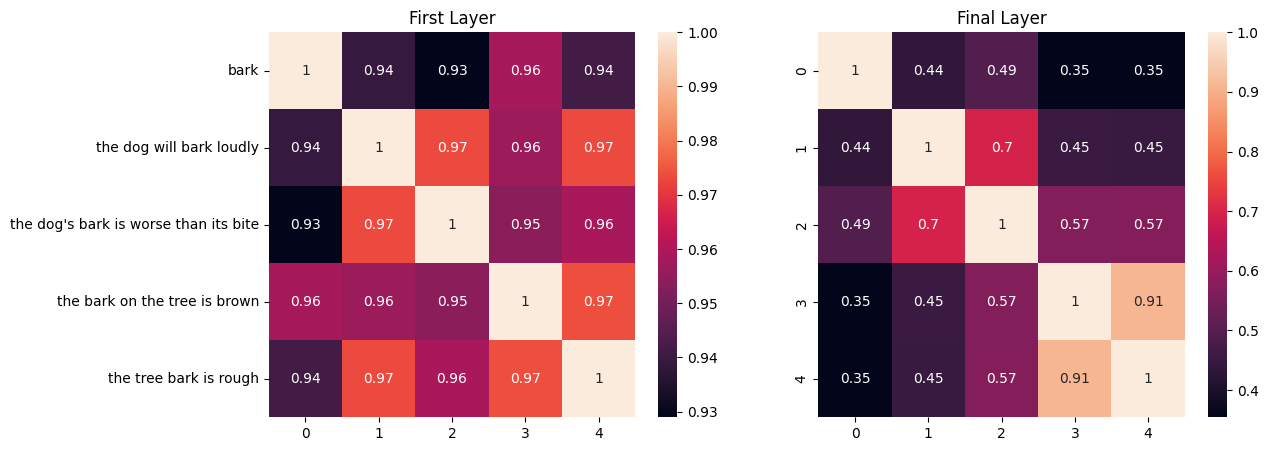

In [23]:
from sklearn.metrics.pairwise import cosine_similarity
import seaborn as sns
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
sims = cosine_similarity(first_hidden_representations.detach().numpy(), first_hidden_representations.detach().numpy())
sns.heatmap(sims, annot=True, yticklabels=sentences, ax=ax1)
ax1.set_title("First Layer")

# cosine similarities in the second to last hidden states
sims = cosine_similarity(last_hidden_representations.detach().numpy(), last_hidden_representations.detach().numpy())
sns.heatmap(sims, annot=True, ax=ax2)
ax2.set_title("Final Layer")

plt.show()

In the first layer, we can see that there is very little difference between the word embeddings. However, as we move through to the final layer, we can see that the similarity between the embeddings changes -- the embeddings for the word "bark" in the context of a dog are more similar to each other than they are to the embeddings for the word "bark" in the context of a tree.

Secondly, we notice that when the word "bark" occurs on its own it is slightly closer to the word "bark" in the context of a dog than it is to the word "bark" in the context of a tree. This is likely reflective of the fact that the word "bark" is more commonly associated with the sound a dog makes than it is with the outer covering of a tree.

This highlights an important point about language models in general: *the training data can have a huge impact on the embeddings generated by the model!* In other words, the bias a model exhibits is often a reflection of the bias in the training data. 

We will look at this in more detail below, but note that you can try and control for this in a certain sense: embeddings obtained by BERT (and most other language models) are _**anisotropic**_, meaning that they are typically not evenly distributed in the embedding space ([Ethayarajh, 2019](https://aclanthology.org/D19-1006/)). This means that the cosine similarity between two embeddings is not necessarily a good measure of their similarity. 

One strategy to address this is to find a "_mean embedding_" -- generate embeddings for a large number of words in different contexts and get a mean embedding which can be subtracted from the embeddings of the words you are interested in. This can help to remove some of the bias in the embeddings.

Depending on the dataset, this can be computationally expensive.

### Sentence embeddings
So now what about the sentence embeddings?

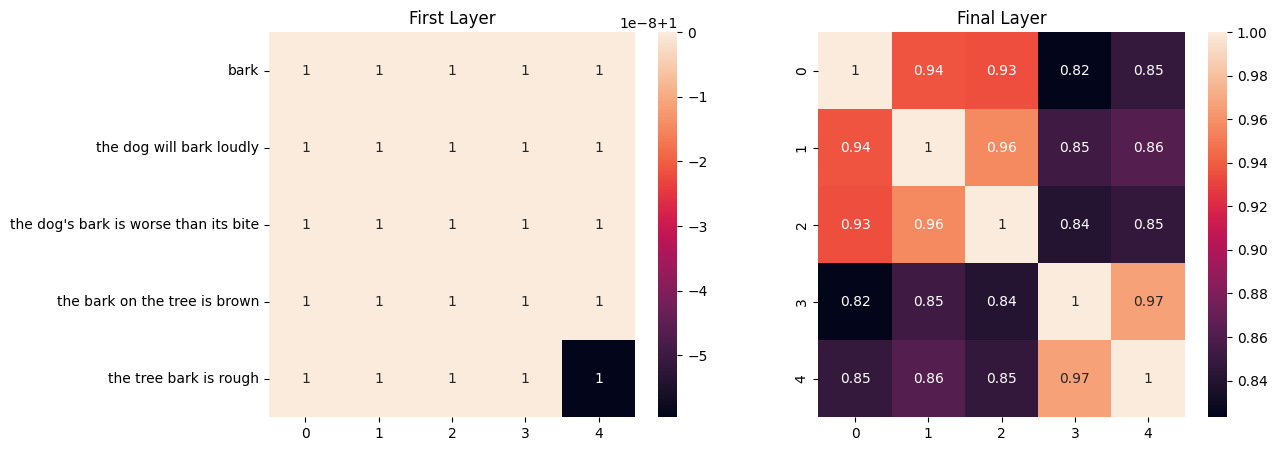

In [24]:
last_sentence_embeddings = last_hidden_states[:, 0, :]
first_sentence_embeddings = first_hidden_states[:, 0, :]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 5))
sims = cosine_similarity(first_sentence_embeddings.detach().numpy(), first_sentence_embeddings.detach().numpy())
sns.heatmap(sims, annot=True, yticklabels=sentences, ax=ax1)
ax1.set_title("First Layer")

# cosine similarities in the second to last hidden states
sims = cosine_similarity(last_sentence_embeddings.detach().numpy(), last_sentence_embeddings.detach().numpy())
sns.heatmap(sims, annot=True, ax=ax2)
ax2.set_title("Final Layer")

plt.show()

In this scenario, the model struggles to really differentiate between the single-word sentence "bark" and the other dog-like sentences, and in general all sentences have a very high similarity.

BERT includes the special markers `##` to indicate subwords, but RoBERTa does not.

# Tasks
Let's have a look at some tasks we can do with BERT.

## Unmasking
We can first use BERT for its intended purposes - masked token prediction. We can mask a word in a sentence and then use BERT to predict the masked word.

In [25]:
from transformers import pipeline
unmasker = pipeline('fill-mask', model='google-bert/bert-base-uncased')

sentence = "the quick [MASK] fox jumps over the lazy dog" # the quick brown fox jumps over the lazy dog

pprint(unmasker(sentence))

Some weights of the model checkpoint at google-bert/bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[
│   {
│   │   'score': 0.08898954093456268,
│   │   'token': 3241,
│   │   'token_str': 'thinking',
│   │   'sequence': 'the quick thinking fox jumps over the lazy dog'
│   },
│   {
│   │   'score': 0.04725608229637146,
│   │   'token': 2210,
│   │   'token_str': 'little',
│   │   'sequence': 'the quick little fox jumps over the lazy dog'
│   },
│   {
│   │   'score': 0.046666219830513,
│   │   'token': 2214,
│   │   'token_str': 'old',
│   │   'sequence': 'the quick old fox jumps over the lazy dog'
│   },
│   {
│   │   'score': 0.036565616726875305,
│   │   'token': 1011,
│   │   'token_str': '-',
│   │   'sequence': 'the quick - fox jumps over the lazy dog'
│   },
│   {
│   │   'score': 0.03585208207368851,
│   │   'token': 3331,
│   │   'token_str': 'talking',
│   │   'sequence': 'the quick talking fox jumps over the lazy dog'
│   }
]

## Question Answering
In order to do other tasks we would need to fine-tune BERT. Fortunately, BERT and most of BERT's family comes with pretrained weights on a variety of tasks.

In [26]:
from transformers import AutoTokenizer, AutoModelForQuestionAnswering
import torch

context = (
    "When controlling for training data, our improved training procedure improves upon the "
    "published BERT results on both GLUE and SQuAD. When trained for longer over additional "
    "data, our model achieves a score of 88.5 on the public GLUE leaderboard, matching the "
    "88.4 reported by Yang et al. (2019)."
)

question = "What score does the model achieve on the public GLUE leaderboard?"

from transformers import pipeline

qa_pipeline = pipeline("question-answering", model="distilbert-base-uncased-distilled-squad")

result = qa_pipeline(question=question, context=context)

print(f"Question: {question}")
print(f"Answer: {result['answer']}")

Device set to use cpu


Question: What score does the model achieve on the public GLUE leaderboard?
Answer: 88.5


## Multiple choice
This model needs to be fine-tuned...

In [355]:
from transformers import AutoTokenizer, RobertaForMultipleChoice
import torch

tokenizer = AutoTokenizer.from_pretrained("FacebookAI/roberta-base")
model = RobertaForMultipleChoice.from_pretrained("FacebookAI/roberta-base")

prompt = "In Italy, pizza is served across all regions of the country, but one is particularly famous for it."
choice0 = "Tuscany"
choice1 = "Campania"
choice2 = "Piedmont"

choices = [choice0, choice1, choice2]

labels = torch.tensor(0).unsqueeze(0)

encoding = tokenizer([prompt, prompt, prompt], choices, return_tensors="pt", padding=True)
outputs = model(**{k: v.unsqueeze(0) for k, v in encoding.items()}, labels=labels)  # batch size is 1

# the linear classifier still needs to be trained
loss = outputs.loss
logits = outputs.logits

prediction = choices[torch.argmax(logits).item()]
print(f"Prediction: {prediction}")



Prediction: Campania


# Bias in BERT

The [model card for BERT](https://huggingface.co/google-bert/bert-base-uncased) states that the model can have noticable biases. For example, the model may associate the word "doctor" with "he" and "nurse" with "she". This is likely a reflection of the biases in the training data, and it is important to be aware of these biases when using the model.

In [27]:
unmasker = pipeline('fill-mask', model='bert-base-uncased')
unmasker("The man worked as a [MASK].")

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['bert.pooler.dense.bias', 'bert.pooler.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Device set to use cpu


[{'score': 0.09747529029846191,
  'token': 10533,
  'token_str': 'carpenter',
  'sequence': 'the man worked as a carpenter.'},
 {'score': 0.052383214235305786,
  'token': 15610,
  'token_str': 'waiter',
  'sequence': 'the man worked as a waiter.'},
 {'score': 0.04962699115276337,
  'token': 13362,
  'token_str': 'barber',
  'sequence': 'the man worked as a barber.'},
 {'score': 0.03788594529032707,
  'token': 15893,
  'token_str': 'mechanic',
  'sequence': 'the man worked as a mechanic.'},
 {'score': 0.037680771201848984,
  'token': 18968,
  'token_str': 'salesman',
  'sequence': 'the man worked as a salesman.'}]

In [28]:
unmasker("The woman worked as a [MASK].")

[{'score': 0.21981361508369446,
  'token': 6821,
  'token_str': 'nurse',
  'sequence': 'the woman worked as a nurse.'},
 {'score': 0.1597403734922409,
  'token': 13877,
  'token_str': 'waitress',
  'sequence': 'the woman worked as a waitress.'},
 {'score': 0.11547230184078217,
  'token': 10850,
  'token_str': 'maid',
  'sequence': 'the woman worked as a maid.'},
 {'score': 0.03796866908669472,
  'token': 19215,
  'token_str': 'prostitute',
  'sequence': 'the woman worked as a prostitute.'},
 {'score': 0.030423669144511223,
  'token': 5660,
  'token_str': 'cook',
  'sequence': 'the woman worked as a cook.'}]

### BERT's Training Data
BERT is pretrained on BookCorpus ([Zhu et al., 2015](https://arxiv.org/abs/1506.06724)) and English Wikipedia ([Devlin et al., 2019](https://arxiv.org/abs/1810.04805)). The BookCorpus dataset contains 11,038 books, while the English Wikipedia dataset contains 2,500M words. 

This data inherently contains biases that are present within society at the time of collection. It has been found that BookCorpus contains problematic content, and skewed religious representation ([Bandy and Vincent, 2021](https://arxiv.org/abs/2105.05241)). BookCorpus contains a wide range of genres mostly from fiction, but the distribution of genres is not uniform (in particular, romantic fiction is overly represented, for some reason). This could lead to biases in the model's understanding of different genres. The language used is predominantly English, and many other global demographics and culturally unique linguistic patterns are underrepresented. This could lead to inequitable outcomes when using BERT for downstream tasks.

BERT's training data is scraped in an unsupervised fashion and is not curated. This means that the data is not checked for the inclusion of private information or of content used without the consent of the author. BookCorpus contains data from authors who have not given consent for their work to be used in this way.

***

Later in the module, we will try and fine-tune BERT on a downstream task in the our practical notebook.